# Gas phase electron diffraction simulation

This notebook describes the way to simulate a gas phase electron diffraction pattern given that we have the atomic cordinates of a molecule. First step is to do the simulation of the radial distribution function from the known molecular geometry inorder to compare it with the experimentally derived ones.

Requirements for a functional code:
1. Geometry file for the intended molecule
2. Kirkland.txt file (included in the repository)
3. Parameters for the detector/experiment

In [27]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import math

In [28]:
### Plotting - Settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] = 'bold'

In order to calculate the theoretical scattering pattern from the molecule we need to compute 

$I_{atom}(s) = \sum_{i=1}^{N} |f_{i}(s)|^2$

as well as

$I_{mol}(s) = \sum_{i=1}^{N} \sum_{j\neq{i}}^{N} |f_{i}(s)||f_{j}(s)|\cos(\eta_i-\eta_j)\frac{\sin(s*r_{ij})}{s*r_{ij}}$

Where $f_{i}$ is the elastic scattering amplitude which can be computed in multiple ways here we follow the method used by:
Earl J. Kirkland. Advanced Computingm in Electron Microscopy. Second Edition. Springer, 2010. 

If we know the experiment parameters, mainly, detector parameters and sample distance the possible electron diffraction parameter forming on the detector can be recreated

$d = \sqrt{(x-xcen)^2+(y-ycen)^2}*pixel size$ 

$\theta = \arctan(\frac{d}{distance-to-the detector})$

$s = \frac{4\pi}{\lambda}Sin(\theta/2)$

$q = 2Sin(\theta/2)/\lambda$

# Scattering factor calculation functions

## Kirkland

In [29]:
#Scattering factor being calculated for the element for a range of s values
def f_x_kirk(s,zi):
    """Scattering factor calculation kirkland method
    
    
    """
    p = kirk_scat(zi)
    q = np.divide(s,math.pi*2)
    
    q_sq = np.multiply(q,q)
    
    f = np.divide(p['a1'],q_sq+p['b1'])+np.divide(p['a2'],q_sq+p['b2'])+np.divide(p['a3'],q_sq+p['b3'])
    
    f = f + p['c1']*np.exp(-p['d1']*q_sq) + p['c2']*np.exp(-p['d2']*q_sq) + p['c3']*np.exp(-p['d3']*q_sq)
    
    return f

## Other Sub functions

In [30]:
def kirk_scat(zi):
    """ The function takes in the atomic number and returns the scattering (Kirkland) function constant values for 
        that specific atom
        Input = Z (Atomic number)
        Output = Scattering vector dictionary with constants (form factors)
    """
    ab_vals = ['a1','b1','a2','b2','a3','b3','c1','d1','c2','d2','c3','d3'] 
    kirkland_path = os.path.join(os.getcwd(),'KirklandScattering.txt')
    kirkland = pd.read_csv(kirkland_path,sep ='\s+', header=None)
    s_fact = np.array(kirkland.iloc[zi-1])
    s_fact = dict(zip(ab_vals,s_fact))
    return s_fact
#--------------------------------------------------------------------------------
def find_z(xyz):
    """ This functon retuns the atomic numbers of the elements in the molecule into a list
        (Currently only functional for H,C and O)
    """
    z = []
    for i in range(len(xyz)):
        if xyz.iloc[i,0] == 'H':
            z.append(1)
        elif xyz.iloc[i,0] == 'C':
            z.append(6)
        elif xyz.iloc[i,0] == 'O':
            z.append(8)
    return z
#--------------------------------------------------------------------------------
def scattering_int(xyz,dim,N_atoms,s):
    """
    Calculates the scattering intensity
    Input parameters: xyz = geometry data
                      dim = detector size in pixels 
                      N_atoms = Number of atoms in the molecule
                      s = scattering vector calculated in the main program body
    output: Iat = Atomic scattering intensity
            Imol = Molecular scattering intensity
    
    """
    IAt = np.zeros(dim)
    Imol = np.zeros(dim)

    pi = 0
    Z = find_z(xyz)
 
    for i in range(N_atoms):
        for j in range(i+1):
            zi = Z[i]
            zj = Z[j]
            print('Zi = {}, Zj = {}'.format(zi,zj))
            
            #fi,fj are the elastic scattering amplitude of atoms
            fi = f_x_kirk(s,zi)
            fj = f_x_kirk(s,zj)
            
            if (i == j):
                IAt = IAt + np.multiply(fi,fj)
                print('rij = 0')
                
            else:
                #We can divide the Imol(s) into 3 parts, first the scatering factor
                #second the cos (phase) factor and 3rd the sin factor
                
                #scat factor calculation
                scat_fact = np.multiply(fi,fj)
                
                #sin factor calculation 
                r1 = xyz.iloc[i,1]-xyz.iloc[j,1]
                r2 = xyz.iloc[i,2]-xyz.iloc[j,2]
                r3 = xyz.iloc[i,3]-xyz.iloc[j,3]
                r_squared = r1**2+r2**2+r3**2
                rij = math.sqrt(r_squared);print('rij = {}'.format(rij))
                sin_fact = np.divide(np.sin(np.multiply(rij,s)),np.multiply(rij,s))            
                
                #cos_factor calculation 
                
                #total
                Imol = Imol + np.multiply(scat_fact,sin_fact)
            pi=pi+1        
            print('Pairs = {}'.format(pi))
    return IAt, Imol               

## Geometry file 

In [31]:
#reading the .xyz file for the corresponding molecule into a dataframe
xyz_file_path = os.getcwd()
xyz_file_name ='Glycerol.xyz'
xyz = pd.read_csv(os.path.join(xyz_file_path,xyz_file_name), sep = '\s+', dtype='str',names = ['Atoms', 'x', 'y', 'z'])
xyz.iloc[0,0]
xyz[["x", "y", "z"]] = xyz[["x", "y", "z"]].apply(pd.to_numeric)
print(len(xyz))
print(xyz)
find_z(xyz)

14
   Atoms       x       y       z
0      H -1.5964 -0.5564  1.4291
1      H -0.1539 -1.5411  0.9655
2      C -0.8261 -0.7228  0.6525
3      H  0.3580  0.8928  1.4421
4      C -0.0281  0.5610  0.4627
5      H  1.6473  1.3274 -0.6389
6      H  0.7861 -0.0286 -1.4421
7      C  1.1615  0.3472 -0.4707
8      H  2.7417 -0.7749 -0.4664
9      O  2.0324 -0.5858  0.1611
10     H -2.0671 -1.7004 -0.4915
11     O -1.4303 -0.9858 -0.6191
12     H -1.4115  1.1333 -0.7032
13     O -0.8706  1.5885 -0.0372


[1, 1, 6, 1, 6, 1, 1, 6, 1, 8, 1, 8, 1, 8]

## Constants

In [32]:
import math
KE = 50 #kinetic energy of electrons kev
planck_c = 4.135667516e-15 #planck constant
m0 = 9.10938215e-31 #rest mass of electron
speed_light = 299792458 #Speed of light
lambda_e = (planck_c*speed_light/(math.sqrt(KE*1000*(KE*1000+2*m0*speed_light**2*6.241506363e+18)))); print(lambda_e)

5.3553082697833555e-12


## Detector parameters 

In [33]:
#Defining the detector parameters this can be adapted from the experiment
xcen = 391.55 #center of the diffraction
ycen = 393.03 #center of the diffraction
pixel_size_det = 4.8e-5 #size of the pixel
shape_det = [900,900]
distanceDet = 0.5 # in m
wavel = lambda_e*1e10; 
print('Wave length of electrons = {} Amstrogs'.format(wavel)) #for 50kv electrons
N_atoms = len(xyz); print('Number of atoms in the molecule = {}'.format(N_atoms))
pairs = int(N_atoms*(N_atoms-1)/2); print('Number of pairs of atomic connections in the molecule = {}'.format(pairs)); 
r = np.zeros(pairs)

Wave length of electrons = 0.05355308269783356 Amstrogs
Number of atoms in the molecule = 14
Number of pairs of atomic connections in the molecule = 91


## Creating a matrix with the respective s values

In [34]:
sM = np.zeros(shape_det); sM.shape

#centersM = [shape_det[0]/2 + 0.00001,shape_det[1]/2 + 0.00001] #center of the image shifted from the actual center to avoid dividing by zero
#xcen = centersM[0]
#ycen = centersM[1]

x = np.arange(1,shape_det[0])
y = np.arange(1,shape_det[1])
[xx,yy] = np.meshgrid(x,y)

#Calculates the distance of each px to the center of the image in meters and in s units.
d = []

for x,y in zip(xx,yy):
    temp_holder = ((x-xcen)**2)+((y-ycen)**2)
    #print(temp_holder)
    d.append(np.sqrt(temp_holder)*pixel_size_det)

theta = np.arctan(np.divide(d,distanceDet))

four_pi_lam  = 4*math.pi/wavel             

s = np.multiply(np.sin(np.divide(theta,2)),four_pi_lam)

np.max(s)

8.056983773323804

## Simulation  of electron diffraction pattern 

In [35]:
Iatom, Imol = scattering_int(xyz=xyz, dim = [899,899], s=s,N_atoms=14);

Zi = 1, Zj = 1
rij = 0
Pairs = 1
Zi = 1, Zj = 1
rij = 1.8070321801229772
Pairs = 2
Zi = 1, Zj = 1
rij = 0
Pairs = 3
Zi = 6, Zj = 1
rij = 1.1064170145112557
Pairs = 4
Zi = 6, Zj = 1
rij = 1.1042810919326653
Pairs = 5
Zi = 6, Zj = 6
rij = 0
Pairs = 6
Zi = 1, Zj = 1
rij = 2.4331109715752794
Pairs = 7
Zi = 1, Zj = 1
rij = 2.532401701942249
Pairs = 8
Zi = 1, Zj = 6
rij = 2.1530732291308627
Pairs = 9
Zi = 1, Zj = 1
rij = 0
Pairs = 10
Zi = 6, Zj = 1
rij = 2.154547889929579
Pairs = 11
Zi = 6, Zj = 1
rij = 2.1650537845513216
Pairs = 12
Zi = 6, Zj = 6
rij = 1.523473163531278
Pairs = 13
Zi = 6, Zj = 1
rij = 1.1038065093122074
Pairs = 14
Zi = 6, Zj = 6
rij = 0
Pairs = 15
Zi = 1, Zj = 1
rij = 4.2833300281439906
Pairs = 16
Zi = 1, Zj = 1
rij = 3.747894482239328
Pairs = 17
Zi = 1, Zj = 6
rij = 3.4624762179688684
Pairs = 18
Zi = 1, Zj = 1
rij = 2.486309041531241
Pairs = 19
Zi = 1, Zj = 6
rij = 2.1465918755087094
Pairs = 20
Zi = 1, Zj = 1
rij = 0
Pairs = 21
Zi = 1, Zj = 1
rij = 3.768112064416344
Pairs 

Text(0.5, 1.0, 'Itot')

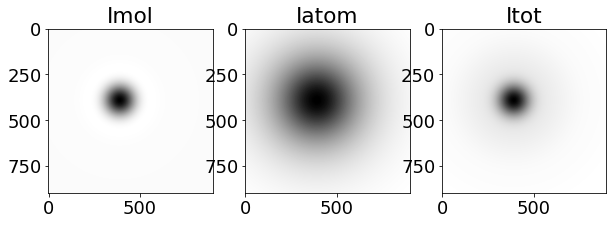

In [36]:
Itot = Imol + Iatom

plt.figure(figsize=(10,27))
plt.subplot(1,3,1)
plt.imshow(Imol, cmap = 'binary')
plt.title('Imol')
plt.subplot(1,3,2)
plt.imshow(Iatom, cmap = 'binary')
plt.title('Iatom')
plt.subplot(1,3,3)
plt.imshow(Itot, cmap = 'binary')
plt.title('Itot')

(-50.0, 50.0)

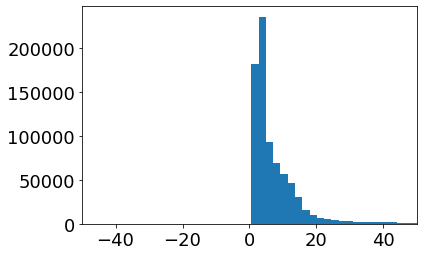

In [37]:
plt.hist(Itot.ravel(), bins = 80);
plt.xlim([-50,50])

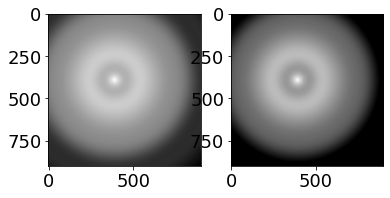

In [38]:
SM = np.multiply(np.divide(Itot,Iatom),s)
plt.subplot(1,2,1)
plt.imshow(SM,cmap = 'binary')
plt.subplot(1,2,2)
plt.imshow(SM,vmin=0, vmax=6, cmap = 'binary')

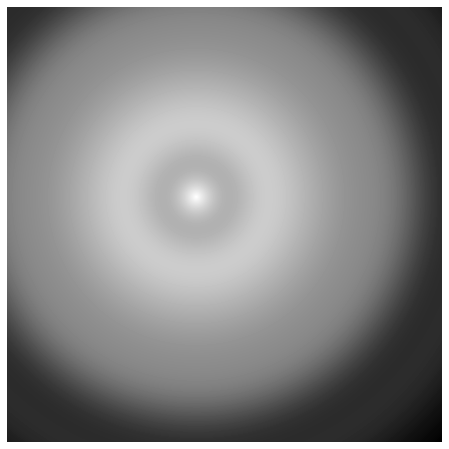

In [39]:
plt.figure(figsize=(8,8))
plt.imshow(SM, cmap = 'binary')
plt.axis('off')
plt.savefig('diffraction_modified_scattering_glycerol_isolated.png', bbox_inches='tight', transparent=True, pad_inches=0.0) #saving without borders


In [40]:
#Incorporating the maks in order to compare the theory with corresponding experiments
def mask_primary(img):
    [x,y] = np.shape(img)
    mask = np.zeros([x,y])
    def pointcheck(xp,yp):
        x1,x2,x3,x4 = [400,400,0,0]
        y1,y2,y3,y4 = [350,400,400,350]
        d1 = (x1-x2)*(yp-y1)-(xp-x1)*(y2-y1)
        d2 = (x2-x3)*(yp-y2)-(xp-x2)*(y3-y2)
        d3 = (x4-x3)*(yp-y3)-(xp-x3)*(y4-y3)
        d4 = (x1-x4)*(yp-y4)-(xp-x4)*(y1-y4)
    
        if d1<0 and d2<0 and d3>0 and d4>0:
            return False
        else:
            return True
    def circl(x,y):
        rr = math.sqrt((x-xcen)**2+(y-ycen)**2)
        if rr<=400 and rr>=50:
            return True
        else:
            return False   
    for i in range(x):
        for j in range(y):
            mask[i,j] = pointcheck(i,j)*circl(i,j)
    return mask

Text(0.5, 1.0, 'Theoretically produced diffraction pattern after applying the mask')

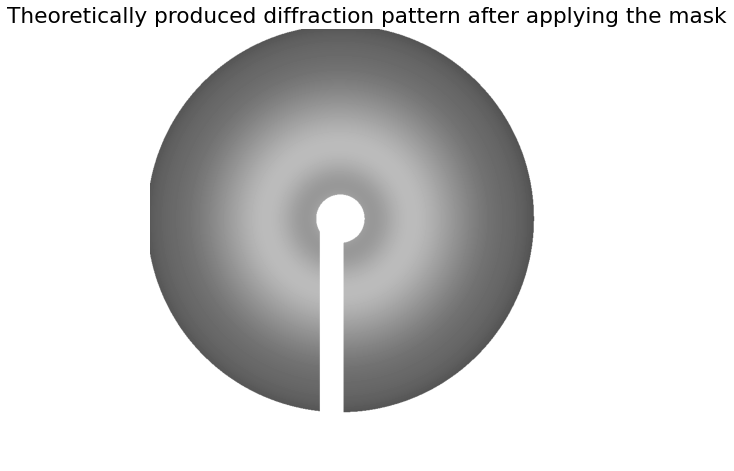

In [41]:
masked = mask_primary(SM)*SM
plt.figure(figsize=(8,8))
plt.imshow(masked,vmin=0, vmax=6, cmap = 'binary')
plt.axis('off')
plt.title('Theoretically produced diffraction pattern after applying the mask')